### W207 Final Project
### Spring 2020
### Kaggle Challenge: Facial Keypoints Detection
### Part 2 of 3
### Sang-hyeb Lee, Haerang Lee, Julia Ying

# 1. Load saved data from Part 1

The following code assumes the notebook for Part 1 was executed, or the outputs from Part 1 was downloaded from [Google Drive](https://drive.google.com/drive/folders/1zfT8Hlp32RHILd6cNq0CZ3pTM7m1A7vS?usp=sharing) and saved into the mounted Google Drive. It assume there is a folder "facial_recognition" inside the mounted GoogleDrive, and that inside that folder, there are four subfolders: "resources", "results", "weights", "models".

**The entire notebook takes about 24 hours to run**, we recommend skipping ahead to part 3 using the final selected models from the Google Drive instead of training the models from scratch here.

In [0]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


keras version: 2.3.0-tf
X_train: (6000, 96, 96, 1)
Y_train: (6000, 30)
Y_dev (768, 30)


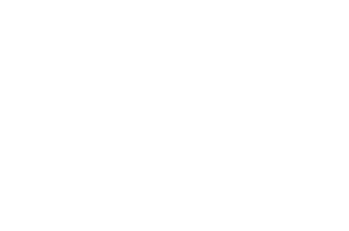

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import pickle

print(f"keras version: {keras.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
IMAGE_WIDTH = 96

np.random.seed(0)

# load data
X_train = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_img.pkl", "rb" ) )
Y_train_ffill = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_ffill.pkl", "rb" ) )
Y_train_median = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_median.pkl", "rb" ) )
Y_train_knn = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_knn.pkl", "rb" ) )

X_dev = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_img.pkl", "rb" ) )
Y_dev_ffill = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_ffill.pkl", "rb" ) )
Y_dev_median = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_median.pkl", "rb" ) )
Y_dev_knn = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_knn.pkl", "rb" ) )

# take the first 768 data points (3 batches) in the dev set for training validation
X_dev = X_dev[:768]
Y_dev_ffill = Y_dev_ffill[:768]
Y_dev_median = Y_dev_median[:768]
Y_dev_knn = Y_dev_knn[:768]

print('X_train:', X_train.shape)
print('Y_train:', Y_train_ffill.shape)
print('Y_dev', Y_dev_ffill.shape)

# 2. Helper section

In [0]:
# helper function to plot the validation result from the model
def plot_history(history, name):
  plt.figure(figsize=(12,8))

  plt.plot(history['loss'], linewidth=3,color = "red", alpha = 0.8, label='loss')
  plt.plot(history['mae'], linewidth=3,color = "blue", alpha = 0.8, label='mae')

  if 'val_loss' in history:
    plt.plot(history['val_loss'], "--", linewidth=3, color = "red", alpha = 0.8, label='val_loss')
    plt.plot(history['val_mae'], "--", linewidth=3, color = "blue", alpha = 0.8, label='val_mae')
  
  plt.yscale("log")
  plt.xlabel("epoch")
  plt.ylabel("log value")
  plt.title(name)
  plt.legend()
  plt.grid(True)
  plt.show()

# custom callback for training the CNN, saves at each epoch
# tracks minimal val_loss achieved with this variant of model, and 
# places and alert whenever a new minimal occurs
class StopAndSaveCallback(keras.callbacks.Callback): 
  def __init__(self, min_loss, save_path):
    self.min_loss = min_loss
    self.save_path = save_path
  def on_epoch_end(self, epoch, logs):
    # attempt and prefix are global variables defined later
    self.model.save_weights(f"{self.save_path}/{prefix}_run{attempt}_ep{epoch}.h5")
    if logs["val_loss"] < self.min_loss:
      self.min_loss = logs["val_loss"]
      print(f'new minimal loss_val, run {attempt}, epoch {epoch}')
      print(logs)


# 3. LeNet5

In [0]:
def create_naive_LeNet5_model(input_shape):
  # helper function that creates a LeNet5 CNN model, input is an integer indicating the shape of each training input
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape))
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=30))
  return model


### 3.1 LeNet5 + ffill

In [0]:
prefix = 'LeNet5_ffill'
result_dict = {}

# build in early stop call back monitoring val_loss,
# if val_loss does not improve by 0.2 after 10 epochs, terminate training early
stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')

# instantiate a new callback function setting the minimal loss at 1000
# when the model achieves val_loss lower than 1000, the alert will trigger
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')

    # create and compile a new LeNet model
    LeNet5_ffill = create_naive_LeNet5_model(X_train.shape[1:])
    LeNet5_ffill.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

    # train for up to 200 epochs and save result
    result = LeNet5_ffill.fit(X_train, Y_train_ffill, epochs = 200, batch_size = 256, validation_split = 0, 
                              validation_data = (X_dev, Y_dev_ffill), verbose = 0, callbacks=[save_callback, stop_callback])
    result_dict[f'run{attempt}_result'] = result.history

# save the results of the 50 training attempts
pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
new minimal loss_val, run 1, epoch 0
{'loss': 1810.0228271484375, 'mae': 31.468547821044922, 'val_loss': 286.1530456542969, 'val_mae': 13.441841125488281}
new minimal loss_val, run 1, epoch 1
{'loss': 380.8692321777344, 'mae': 15.272432327270508, 'val_loss': 154.47608947753906, 'val_mae': 9.471949577331543}
new minimal loss_val, run 1, epoch 2
{'loss': 280.9880676269531, 'mae': 12.95702838897705, 'val_loss': 114.2281723022461, 'val_mae': 8.182570457458496}
new minimal loss_val, run 1, epoch 3
{'loss': 232.46556091308594, 'mae': 11.738840103149414, 'val_loss': 106.16478729248047, 'val_mae': 7.823079586029053}
new minimal loss_val, run 1, epoch 8
{'loss': 141.59132385253906, 'mae': 9.055821418762207, 'val_loss': 85.77175903320312, 'val_mae': 6.935238361358643}
run 2
run 3
new minimal loss_val, run 3, epoch 10
{'loss': 105.0278549194336, 'mae': 7.768831253051758, 'val_loss': 84.67929077148438, 'val_mae': 6.909529209136963}
run 4
new minimal loss_val, run 4, epoch 10
{'loss': 97.9499

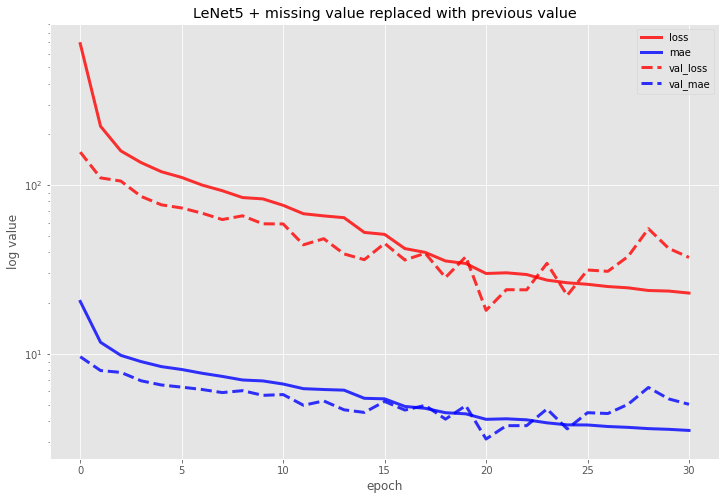

In [0]:
# plot the history of the record holder
plot_history(result_dict['run44_result'],'LeNet5 + missing value replaced with previous value')

### 3.1 LeNet5 + median

In [0]:
prefix = 'LeNet5_median'
result_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')
    LeNet5_median = create_naive_LeNet5_model(X_train.shape[1:])
    LeNet5_median.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    result = LeNet5_median.fit(X_train, Y_train_median, epochs = 200, batch_size = 256, validation_split = 0, 
                              validation_data = (X_dev, Y_dev_median), verbose = 0, callbacks=[save_callback, stop_callback])
      
    result_dict[f'run{attempt}_result'] = result.history

pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
new minimal loss_val, run 1, epoch 0
{'loss': 3644.841796875, 'mae': 43.35986328125, 'val_loss': 620.065185546875, 'val_mae': 20.51811981201172}
new minimal loss_val, run 1, epoch 1
{'loss': 605.7910766601562, 'mae': 19.45477294921875, 'val_loss': 229.22877502441406, 'val_mae': 11.905558586120605}
new minimal loss_val, run 1, epoch 2
{'loss': 354.98095703125, 'mae': 14.674861907958984, 'val_loss': 175.67958068847656, 'val_mae': 10.214900016784668}
new minimal loss_val, run 1, epoch 3
{'loss': 274.1492004394531, 'mae': 12.804239273071289, 'val_loss': 159.92689514160156, 'val_mae': 9.775189399719238}
new minimal loss_val, run 1, epoch 4
{'loss': 224.1681671142578, 'mae': 11.480104446411133, 'val_loss': 117.34236907958984, 'val_mae': 8.23488712310791}
new minimal loss_val, run 1, epoch 5
{'loss': 187.06163024902344, 'mae': 10.424004554748535, 'val_loss': 113.0487289428711, 'val_mae': 8.068894386291504}
new minimal loss_val, run 1, epoch 6
{'loss': 162.9051513671875, 'mae': 9.6479253

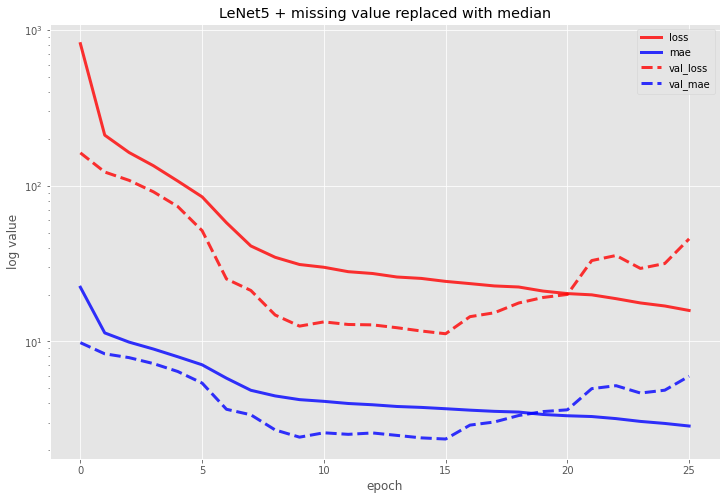

In [0]:
plot_history(result_dict['run21_result'],'LeNet5 + missing value replaced with median')

### 3.3 LeNet5 + KNN

In [0]:
prefix = 'LeNet5_knn'
result_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')
    LeNet5_knn = create_naive_LeNet5_model(X_train.shape[1:])
    LeNet5_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    result = LeNet5_knn.fit(X_train, Y_train_knn, epochs = 200, batch_size = 256, validation_split = 0, 
                            validation_data = (X_dev, Y_dev_knn), verbose = 0, callbacks=[save_callback, stop_callback])
    result_dict[f'run{attempt}_result'] = result.history

pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
new minimal loss_val, run 1, epoch 0
{'loss': 1604.8466796875, 'mae': 29.7884578704834, 'val_loss': 272.32708740234375, 'val_mae': 13.11197280883789}
new minimal loss_val, run 1, epoch 1
{'loss': 378.6252136230469, 'mae': 15.24025821685791, 'val_loss': 162.91636657714844, 'val_mae': 9.642367362976074}
new minimal loss_val, run 1, epoch 2
{'loss': 259.3216552734375, 'mae': 12.473664283752441, 'val_loss': 124.42293548583984, 'val_mae': 8.395840644836426}
new minimal loss_val, run 1, epoch 3
{'loss': 215.98106384277344, 'mae': 11.346397399902344, 'val_loss': 123.61278533935547, 'val_mae': 8.432843208312988}
new minimal loss_val, run 1, epoch 4
{'loss': 185.35015869140625, 'mae': 10.417251586914062, 'val_loss': 99.64337158203125, 'val_mae': 7.530971527099609}
new minimal loss_val, run 1, epoch 9
{'loss': 109.62860870361328, 'mae': 7.874499797821045, 'val_loss': 94.02042388916016, 'val_mae': 7.2757439613342285}
new minimal loss_val, run 1, epoch 17
{'loss': 85.82852172851562, 'mae': 6

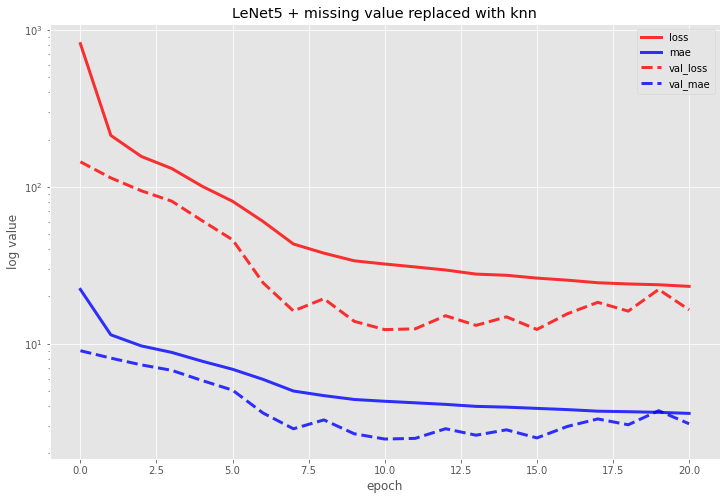

In [0]:
plot_history(result_dict['run40_result'],'LeNet5 + missing value replaced with knn')

# 4. VGG16

In [0]:
def create_vgg16_model_single_channel(input_shape, use_imagenet = False):
  # convert the grayscale input layer to rgb channels
  single_channel_input = keras.layers.Input(shape=input_shape)
  single_channel_concat = keras.layers.concatenate([single_channel_input,single_channel_input,single_channel_input])

  # load VGG16, either with or without pre_trained weights from ImageNet
  if use_imagenet:
    model_layer = keras.applications.VGG16(weights="imagenet", include_top=False)(single_channel_concat)
  else:
    model_layer = keras.applications.VGG16(weights=None, include_top=False)(single_channel_concat)

  # Flatten the output layer to 1 dimension
  x = keras.layers.Flatten()(model_layer)

  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = keras.layers.Dense(1024, activation='relu')(x)

  # Add a dropout rate of 0.2
  x = keras.layers.Dropout(0.2)(x)

  # Add a final sigmoid layer for classification
  x = keras.layers.Dense (30)(x) 
  model = keras.Model(single_channel_input, x) 
  return model

### 4.1 VGG 16 + no weight + KNN

In [0]:
prefix = 'VGG16'
result_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')
    VGG16 = create_vgg16_model_single_channel(X_train.shape[1:])
    VGG16.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    result = VGG16.fit(X_train, Y_train_knn, epochs = 200, batch_size = 256, validation_split = 0, 
                      validation_data = (X_dev, Y_dev_knn), verbose = 0, callbacks=[save_callback, stop_callback])
    result_dict[f'run{attempt}_result'] = result.history

pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
new minimal loss_val, run 1, epoch 1
{'loss': 1694.9130859375, 'mae': 35.93754959106445, 'val_loss': 494.9678039550781, 'val_mae': 19.271753311157227}
new minimal loss_val, run 1, epoch 2
{'loss': 336.9770812988281, 'mae': 14.504867553710938, 'val_loss': 156.28564453125, 'val_mae': 9.581027030944824}
new minimal loss_val, run 1, epoch 3
{'loss': 201.4340057373047, 'mae': 11.176188468933105, 'val_loss': 111.51547241210938, 'val_mae': 7.916688919067383}
new minimal loss_val, run 1, epoch 5
{'loss': 169.7783966064453, 'mae': 10.19892406463623, 'val_loss': 91.80370330810547, 'val_mae': 7.163930416107178}
new minimal loss_val, run 1, epoch 7
{'loss': 130.429931640625, 'mae': 8.8858060836792, 'val_loss': 68.3199691772461, 'val_mae': 6.174417972564697}
new minimal loss_val, run 1, epoch 8
{'loss': 117.52205657958984, 'mae': 8.480571746826172, 'val_loss': 56.5435905456543, 'val_mae': 5.633754253387451}
new minimal loss_val, run 1, epoch 9
{'loss': 101.87539672851562, 'mae': 7.87280797958

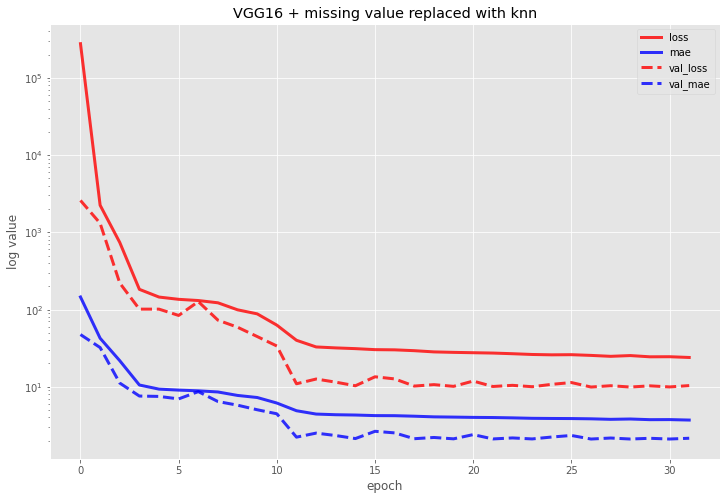

In [0]:
plot_history(result_dict['run28_result'],'VGG16 + missing value replaced with knn')

### 4.2 VGG 16 + ImageNet + KNN

In [0]:
prefix = 'VGG16_imagenet'
result_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')
    VGG16_imagenet = create_vgg16_model_single_channel(X_train.shape[1:], use_imagenet = True)
    VGG16_imagenet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    result = VGG16_imagenet.fit(X_train, Y_train_knn, epochs = 200, batch_size = 256, validation_split = 0, 
                                validation_data = (X_dev, Y_dev_knn), verbose = 0, callbacks=[save_callback, stop_callback])
    result_dict[f'run{attempt}_result'] = result.history

pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
58892288/58889256 [==============================] - 0s 0us/step
new minimal loss_val, run 1, epoch 0
{'loss': 15547089.0, 'mae': 789.6183471679688, 'val_loss': 385.7156066894531, 'val_mae': 16.096952438354492}
new minimal loss_val, run 1, epoch 1
{'loss': 309.60552978515625, 'mae': 13.808761596679688, 'val_loss': 211.6581573486328, 'val_mae': 11.429913520812988}
new minimal loss_val, run 1, epoch 2
{'loss': 226.79786682128906, 'mae': 11.642709732055664, 'val_loss': 179.89476013183594, 'val_mae': 10.295475959777832}
new minimal loss_val, run 1, epoch 3
{'loss': 207.68663024902344, 'mae': 11.072237968444824, 'val_loss': 140.2305908203125, 'val_mae': 8.831645965576172}
new minimal loss_val, run 1, epoch 4
{'loss': 176.7538299560547, 'mae': 10.167110443115234, 'val_loss': 115.31000518798828, 'val_mae': 8.016854286193848}
new minimal loss_val, run 1, epoch 7
{'loss': 146.7664337158203, 'mae': 9.320561408996582, 'val_loss': 101.33209228515625, 'val_mae': 7.592641353607178}
new minimal

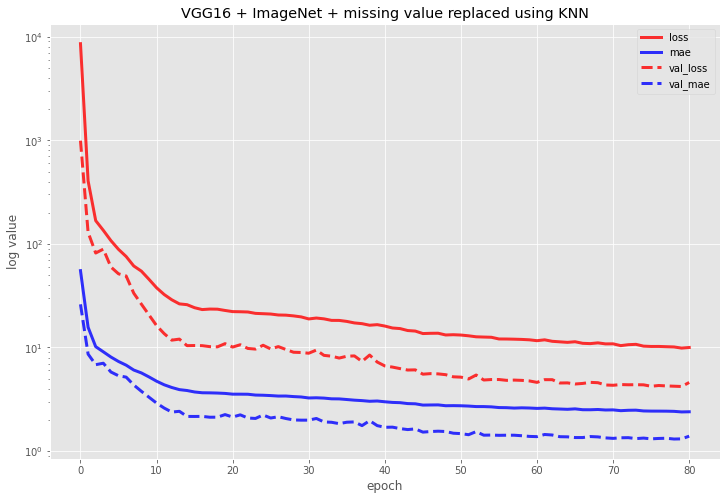

In [0]:
plot_history(result_dict['run43_result'],'VGG16 + ImageNet + missing value replaced using KNN')

# 5. VGG19

In [0]:
def create_vgg19_model_single_channel(input_shape, use_imagenet = False):
  # convert the grayscale input layer to rgb channels
  single_channel_input = keras.layers.Input(shape=input_shape)
  single_channel_concat = keras.layers.concatenate([single_channel_input,single_channel_input,single_channel_input])
  # load VGG19, either with or without pre_trained weights from ImageNet
  if use_imagenet:
    model_layer = keras.applications.VGG19(weights="imagenet", include_top=False)(single_channel_concat)
  else:
    model_layer = keras.applications.VGG19(weights=None, include_top=False)(single_channel_concat)
  # Flatten the output layer to 1 dimension
  x = keras.layers.Flatten()(model_layer)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = keras.layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = keras.layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = keras.layers.Dense (30)(x) 
  model = keras.Model(single_channel_input, x) 
  return model

### 5.1 VGG 19 + no weight + KNN

In [0]:
prefix = 'VGG19'
result_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')
    VGG19 = create_vgg19_model_single_channel(X_train.shape[1:])
    VGG19.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    result = VGG19.fit(X_train, Y_train_knn, epochs = 200, batch_size = 256, validation_split = 0, 
                      validation_data = (X_dev, Y_dev_knn), verbose = 0, callbacks=[save_callback, stop_callback])
    result_dict[f'run{attempt}_result'] = result.history

pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
new minimal loss_val, run 1, epoch 4
{'loss': 1028.26904296875, 'mae': 26.307083129882812, 'val_loss': 127.23339080810547, 'val_mae': 8.59085464477539}
new minimal loss_val, run 1, epoch 5
{'loss': 244.6619415283203, 'mae': 12.385846138000488, 'val_loss': 123.19366455078125, 'val_mae': 8.348018646240234}
new minimal loss_val, run 1, epoch 6
{'loss': 195.64398193359375, 'mae': 10.983351707458496, 'val_loss': 114.45020294189453, 'val_mae': 8.093809127807617}
new minimal loss_val, run 1, epoch 9
{'loss': 160.0307159423828, 'mae': 9.807625770568848, 'val_loss': 104.00910186767578, 'val_mae': 7.802865505218506}
new minimal loss_val, run 1, epoch 10
{'loss': 147.0797576904297, 'mae': 9.335427284240723, 'val_loss': 92.13152313232422, 'val_mae': 7.235063552856445}
new minimal loss_val, run 1, epoch 11
{'loss': 136.8865509033203, 'mae': 8.98808765411377, 'val_loss': 83.2198257446289, 'val_mae': 6.927606105804443}
new minimal loss_val, run 1, epoch 14
{'loss': 124.48794555664062, 'mae': 8.

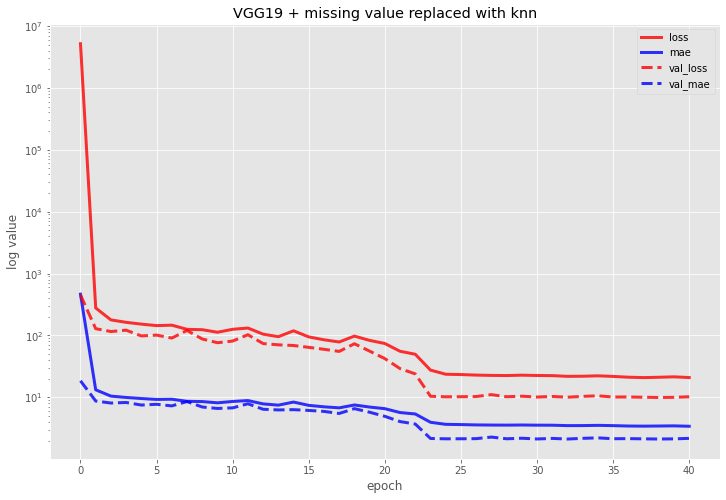

In [0]:
plot_history(result_dict['run40_result'],'VGG19 + missing value replaced with knn')

### 5.2 VGG 19 + ImageNet + KNN

In [0]:
prefix = 'VGG19_imagenet'
result_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')
    VGG19 = create_vgg19_model_single_channel(X_train.shape[1:], use_imagenet = True)
    VGG19.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    result = VGG19.fit(X_train, Y_train_knn, epochs = 200, batch_size = 256, validation_split = 0, 
                      validation_data = (X_dev, Y_dev_knn), verbose = 0, callbacks=[save_callback, stop_callback])
    result_dict[f'run{attempt}_result'] = result.history

pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
80142336/80134624 [==============================] - 1s 0us/step
new minimal loss_val, run 1, epoch 1
{'loss': 500.6686096191406, 'mae': 17.360477447509766, 'val_loss': 136.3484344482422, 'val_mae': 8.994327545166016}
new minimal loss_val, run 1, epoch 2
{'loss': 201.6692657470703, 'mae': 11.22755241394043, 'val_loss': 110.53305053710938, 'val_mae': 7.9259033203125}
new minimal loss_val, run 1, epoch 3
{'loss': 177.7836456298828, 'mae': 10.470900535583496, 'val_loss': 106.54618072509766, 'val_mae': 7.782948970794678}
new minimal loss_val, run 1, epoch 6
{'loss': 143.9007110595703, 'mae': 9.293521881103516, 'val_loss': 98.2480697631836, 'val_mae': 7.590914249420166}
new minimal loss_val, run 1, epoch 10
{'loss': 223.2171630859375, 'mae': 11.61083698272705, 'val_loss': 98.1437759399414, 'val_mae': 7.471752166748047}
new minimal loss_val, run 1, epoch 11
{'loss': 136.65237426757812, 'mae': 8.996723175048828, 'val_loss': 93.66985321044922, 'val_mae': 7.262998104095459}
new minimal lo

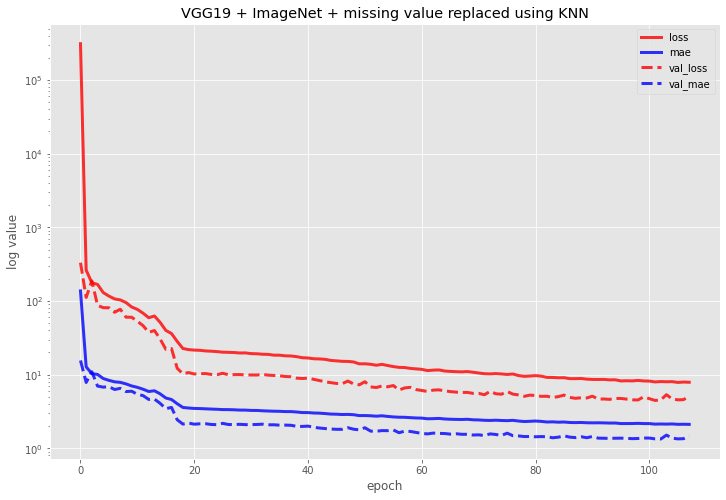

In [0]:
plot_history(result_dict['run42_result'],'VGG19 + ImageNet + missing value replaced using KNN')

# 6. Data Augmentation

In [0]:
from scipy.ndimage import rotate, shift
import math

class FacialPointImageDataGenerator(keras.utils.Sequence):
    """FacialPointImageDataGenerator"""
    def __init__(
        self,
        X_data,
        y_data,
        horizontal_flip_prob=0,
        horizontall_flip_label=None,
        shift_range=3,
        shift_prob=0,
        rotation_deg_range=20,
        rotation_deg_prob=0,
        batch_size=32,
        image_size=(96, 96),
        shuffle=True,
    ):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.horizontal_flip_prob = horizontal_flip_prob
        self.horizontal_center = image_size[0] // 2
        self.horizontal_flip_batch_size = int(horizontal_flip_prob * batch_size)
        # need to update the labels if we flip the image horizontally
        # for example left_eye_center_x becomes right_eye_center_x
        self.horizontal_flip_label = (
            {
                "orig": [0, 1, 4, 5, 6, 7, 12, 13, 14, 15, 22, 23],
                "new": [2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25],
            }
            if horizontall_flip_label is None
            else horizontall_flip_label
        )

        self.horizontal_flip_fn = np.vectorize(self.horizontal_flip)
        self.w_shift_max = shift_range
        self.h_shift_max = shift_range
        self.shift_prob = shift_prob
        self.rotation_deg_range = rotation_deg_range
        self.rotation_deg_prob = rotation_deg_prob

        self.y_data = y_data
        self.X_data = X_data
        self.on_epoch_end()

    # helpfer function for performing horizontal flip
    @staticmethod
    def horizontal_flip(element, center):
        if element < center:
            element = center + (center - element)
        else:
            element = center - (element - center)
        return element

    def apply_rotation(self, image_array, kp_array, angle):
        # works with one example at a time
        # image_array is an (1, 96, 96, 1) or (1, 96, 96) or (96, 96) array
        # kp_array is an (1, 30) array
        # angle is an integer

        image = image_array.reshape(96, 96)
        rotated_image = rotate(image, angle, reshape=False)

        # 1 by 2 ndarray, [47.5 47.5] for 96 by 96 image
        org_center = (np.array(image.shape[:2][::-1]) - 1) / 2.0

        # 1 by 2 ndarray of where the original center is on the rotated image
        rot_center = (np.array(rotated_image.shape[:2][::-1]) - 1) / 2.0

        kp_zipped = list(zip(kp_array[::2], kp_array[1::2]))

        # how much the original kp offset from the original center
        offsets = [(np.asarray(xy) - org_center) for xy in kp_zipped]

        # rotation angle as radian
        a = np.deg2rad(angle)

        # calculate the rotated key points's offset from the new rotated center
        new_offsets = [
            np.array(
                [
                    xy[0] * np.cos(a) + xy[1] * np.sin(a),
                    -xy[0] * np.sin(a) + xy[1] * np.cos(a),
                ]
            )
            for xy in offsets
        ]

        # calculate the rotated key points
        new_kp_tuples = [xy + rot_center for xy in new_offsets]

        new_kp = []
        for tup in new_kp_tuples:
            new_kp.append(tup[0])
            new_kp.append(tup[1])

        # if the new key points out of bounds, return the original values
        if (max(new_kp) > 96) | (min(new_kp) < 0):
            return image.reshape(96, 96, 1), kp_array.reshape(30)
        else:
            return rotated_image.reshape(96, 96, 1), np.asarray(new_kp).reshape(30)

    def apply_translation(self, image_array, kp_array, delta_x, delta_y):
        # works with one example at a time
        # image_array is an (1, 96, 96, 1) or (1, 96, 96) or (96, 96) array
        # kp_array is an (1, 30) array, delta_x and delta_y are each integers, 
        # positive delta_x shifts the image to the right, positive delta_y shift the image to the down

        image = image_array.reshape(96, 96)
        shifted_image = shift(image, (delta_y, delta_x))

        new_kp_x = [x + delta_x for x in kp_array[::2]]
        new_kp_y = [y + delta_y for y in kp_array[1::2]]

        new_kp = []
        for tup in zip(new_kp_x, new_kp_y):
            new_kp.append(tup[0])
            new_kp.append(tup[1])

        # if the new key points out of bounds, return the original values
        if (max(new_kp) > 96) | (min(new_kp) < 0):
            return image.reshape(96, 96, 1), kp_array.reshape(30)
        else:
            return shifted_image.reshape(96, 96, 1), np.asarray(new_kp).reshape(30)

    def __len__(self):
        """Number of batches per epoch"""
        return self.X_data.shape[0] // self.batch_size

    def on_epoch_end(self):
        """Called at the end of every epoch. Shuffle indices?"""
        self.indexes = np.arange(self.X_data.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """Generate one batch of data"""
        # generate indexes
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # get the data
        X_batch = self.X_data[indexes]
        y_batch = self.y_data[indexes]

        # handle horizontal flip
        if self.horizontal_flip_prob > 0:
            horizontal_flip_index = np.random.choice(
                self.batch_size, self.horizontal_flip_batch_size, replace=False
            )
            X_batch[horizontal_flip_index] = X_batch[horizontal_flip_index, :, ::-1, :]
            for index in horizontal_flip_index:
                target_y = y_batch[index]
                target_y_rotated = self.horizontal_flip_fn(
                    target_y, self.horizontal_center
                )
                target_y_rotated[1::2] = target_y[1::2]
                ## need to flip indicies
                y_batch_orig = target_y_rotated[self.horizontal_flip_label["orig"]]
                target_y_rotated[self.horizontal_flip_label["orig"]] = target_y_rotated[
                    self.horizontal_flip_label["new"]
                ]
                target_y_rotated[self.horizontal_flip_label["new"]] = y_batch_orig
                y_batch[index] = target_y_rotated

        # handle translation
        if self.shift_prob > 0:
            for index in range(self.batch_size):
                delta_x, delta_y = (
                    np.random.uniform(-1 * self.w_shift_max, self.w_shift_max),
                    np.random.uniform(-1 * self.h_shift_max, self.h_shift_max),
                )
                X_batch[index], y_batch[index] = self.apply_translation(
                    X_batch[index], y_batch[index], delta_x, delta_y
                )

        # handle rotation
        if self.rotation_deg_prob > 0:
            for index in range(self.batch_size):
                delta_angle_deg = np.random.uniform(
                    -1 * self.rotation_deg_range, self.rotation_deg_range
                )
                X_batch[index], y_batch[index] = self.apply_rotation(
                    X_batch[index], y_batch[index], delta_angle_deg
                )

        return X_batch, y_batch

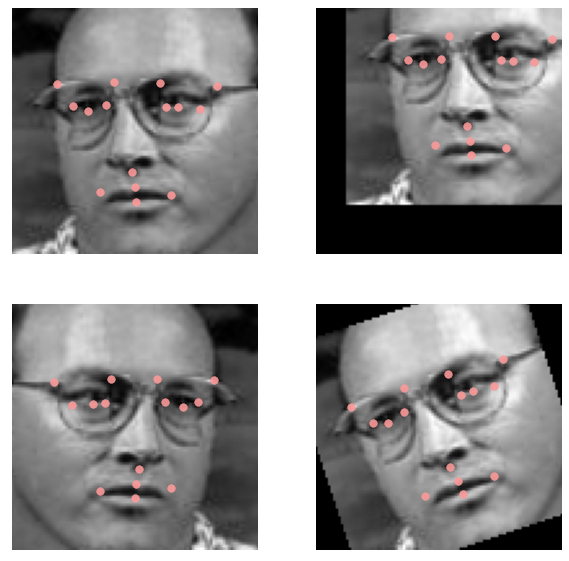

In [0]:
# testthe generator

# get a batch of unchanged images
generator_nochange = FacialPointImageDataGenerator(X_data= X_train, y_data= Y_train_knn, shuffle = False,
                                                   shift_prob=0, horizontal_flip_prob=0, rotation_deg_prob=0)
X_nochange, Y_nochange = generator_nochange[0]

# get a batch of shifted images
generator_shifted = FacialPointImageDataGenerator(X_data = X_train, y_data = Y_train_knn, shuffle = False,
                                                  shift_range = 20, shift_prob = 1, horizontal_flip_prob=0, rotation_deg_prob=0)
X_shifted, Y_shifted = generator_shifted[0]

# get a batch of flipped images
generator_flipped = FacialPointImageDataGenerator(X_data = X_train, y_data = Y_train_knn, shuffle = False,
                                                  shift_prob = 0, horizontal_flip_prob=1, rotation_deg_prob=0)
X_flipped, Y_flipped = generator_flipped[0]

# get a batch of rotated images
generator_rotated = FacialPointImageDataGenerator(X_data = X_train, y_data = Y_train_knn, shuffle = False,
                                                  shift_prob = 0, horizontal_flip_prob=0, rotation_deg_prob=1, rotation_deg_range=20)
X_rotated, Y_rotated = generator_rotated[0]

# grab one example out of each type of X and Y, concatenate them for plotting
X_examples = np.concatenate([X_nochange[1,:].reshape(1, 96, 96), 
                             X_shifted[1,:].reshape(1, 96, 96), 
                             X_flipped[1,:].reshape(1, 96, 96), 
                             X_rotated[1,:].reshape(1, 96, 96)], axis = 0)

Y_examples = np.concatenate([Y_nochange[1,:].reshape(1, 30), 
                             Y_shifted[1,:].reshape(1, 30), 
                             Y_flipped[1,:].reshape(1, 30), 
                             Y_rotated[1,:].reshape(1, 30)], axis = 0)

  fig, ax = plt.subplots(2,2, figsize=(10,10))
  plt.setp(ax, xticks=(), yticks=())  

  # each row in img_array is a picture
  for row in range(4):   
      image = X_examples[row,:]

      # plot image at the appropriate subplot coordinate
      i = int(np.floor(row/2))
      j = int(np.mod(row,2))

      ax[i,j].imshow(image, cmap="gray")

      # create tuples for each key point, each tuple is a pair of x, y
      curr_kp = Y_examples[row,:]    
      kp_zipped = list(zip(curr_kp[::2], curr_kp[1::2]))

      # plot the predicted points as pink circlees
      for p in kp_zipped:
        ax[i,j].scatter(p[0], p[1], s=60, c='#fb9a99', marker='o', alpha = 0.9)

### 6.1 VGG16 + ImageNet continued training + Data Augmentation

In [0]:
prefix = 'VGG16_dataaug_continue'
result_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')

    train_datagen = FacialPointImageDataGenerator(
        X_data= X_train,
        y_data= Y_train_knn,
        shift_range=5,
        shift_prob=0.5,
        rotation_deg_range=20,
        rotation_deg_prob=0.5,
        horizontal_flip_prob=0.5,
        batch_size=256,
        )

    validation_datagen = FacialPointImageDataGenerator(
        X_data= X_dev,
        y_data= Y_dev_knn,
        shift_range=0,
        shift_prob=0,
        rotation_deg_range=20,
        rotation_deg_prob=0,
        horizontal_flip_prob=0,
        batch_size=256,
        )
    
    VGG16_dataaug_continue = create_vgg16_model_single_channel(X_train.shape[1:])
    VGG16_dataaug_continue.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    VGG16_dataaug_continue.load_weights("/content/drive/My Drive/facial_recognition/weights/VGG16_imagenet_run43_ep79.h5")

    result = VGG16_dataaug_continue.fit_generator(generator = train_datagen, validation_data = validation_datagen, 
                                                  epochs=200, verbose = 0, callbacks=[save_callback, stop_callback])
    result_dict[f'run{attempt}_result'] = result.history

pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
Instructions for updating:
Please use Model.fit, which supports generators.
new minimal loss_val, run 1, epoch 0
{'loss': 58.903236389160156, 'mae': 5.140161037445068, 'val_loss': 9.332660675048828, 'val_mae': 2.068288564682007}
new minimal loss_val, run 1, epoch 1
{'loss': 19.06951332092285, 'mae': 3.2566707134246826, 'val_loss': 7.741295337677002, 'val_mae': 1.892679214477539}
new minimal loss_val, run 1, epoch 2
{'loss': 16.432279586791992, 'mae': 3.014101028442383, 'val_loss': 7.058071613311768, 'val_mae': 1.7759639024734497}
new minimal loss_val, run 1, epoch 3
{'loss': 15.43387222290039, 'mae': 2.905663251876831, 'val_loss': 6.866446018218994, 'val_mae': 1.7479230165481567}
new minimal loss_val, run 1, epoch 4
{'loss': 14.05574893951416, 'mae': 2.79714298248291, 'val_loss': 6.253453731536865, 'val_mae': 1.6533504724502563}
new minimal loss_val, run 1, epoch 12
{'loss': 10.721346855163574, 'mae': 2.4446065425872803, 'val_loss': 5.976966381072998, 'val_mae': 1.621358513832092

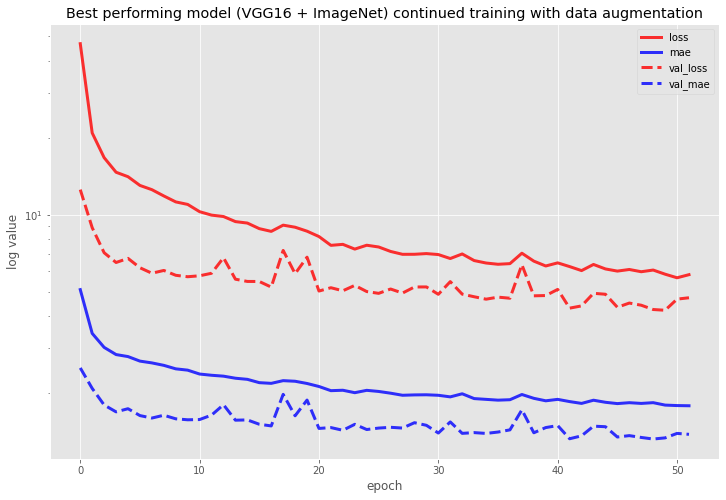

In [0]:
plot_history(result_dict['run31_result'],'Best performing model (VGG16 + ImageNet) continued training with data augmentation')

### 6.2 VGG19 + ImageNet continued training + Data Augmentation

In [0]:
prefix = 'VGG19_dataaug_continue'
result_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, verbose=0, mode='min')
save_callback = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
    print(f'run {attempt}')

    train_datagen = FacialPointImageDataGenerator(
        X_data= X_train,
        y_data= Y_train_knn,
        shift_range=5,
        shift_prob=0.5,
        rotation_deg_range=20,
        rotation_deg_prob=0.5,
        horizontal_flip_prob=0.5,
        batch_size=256,
        )

    validation_datagen = FacialPointImageDataGenerator(
        X_data= X_dev,
        y_data= Y_dev_knn,
        shift_range=0,
        shift_prob=0,
        rotation_deg_range=20,
        rotation_deg_prob=0,
        horizontal_flip_prob=0,
        batch_size=256,
        )
    
    VGG19_dataaug_continue = create_vgg19_model_single_channel(X_train.shape[1:])
    VGG19_dataaug_continue.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    VGG19_dataaug_continue.load_weights("/content/drive/My Drive/facial_recognition/weights/VGG19_imagenet_run42_ep101.h5")

    result = VGG19_dataaug_continue.fit_generator(generator = train_datagen, validation_data = validation_datagen, 
                                                  epochs=200, verbose = 0, callbacks=[save_callback, stop_callback])
    result_dict[f'run{attempt}_result'] = result.history

pickle.dump( result_dict, open( f"/content/drive/My Drive/facial_recognition/results/{prefix}.p", "wb" ) )

run 1
Instructions for updating:
Please use Model.fit, which supports generators.
new minimal loss_val, run 1, epoch 0
{'loss': 1504.6488037109375, 'mae': 12.933564186096191, 'val_loss': 19.45990562438965, 'val_mae': 3.3255856037139893}
new minimal loss_val, run 1, epoch 1
{'loss': 24.278247833251953, 'mae': 3.765047550201416, 'val_loss': 11.120619773864746, 'val_mae': 2.3590800762176514}
new minimal loss_val, run 1, epoch 3
{'loss': 16.754131317138672, 'mae': 3.045982599258423, 'val_loss': 9.326757431030273, 'val_mae': 2.1267378330230713}
new minimal loss_val, run 1, epoch 5
{'loss': 14.165287017822266, 'mae': 2.7657651901245117, 'val_loss': 9.049559593200684, 'val_mae': 2.154231071472168}
new minimal loss_val, run 1, epoch 6
{'loss': 13.40383243560791, 'mae': 2.693006753921509, 'val_loss': 8.704922676086426, 'val_mae': 2.1044530868530273}
new minimal loss_val, run 1, epoch 7
{'loss': 13.035518646240234, 'mae': 2.669384717941284, 'val_loss': 7.241849422454834, 'val_mae': 1.82486498355

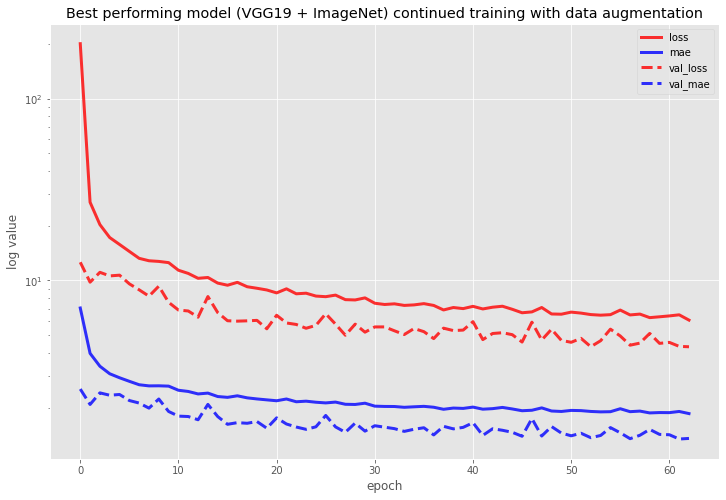

In [0]:
plot_history(result_dict['run18_result'],'Best performing model (VGG19 + ImageNet) continued training with data augmentation')

# 7. Loading Best Weights and Save Models

Load saved weights because most likely the runtime for this notebook has been interrupted.

### 7.1 LeNet5 + ffill

In [0]:
# create and compile model
LeNet5_ffill = create_naive_LeNet5_model(X_dev.shape[1:])
LeNet5_ffill.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
LeNet5_ffill.load_weights("/content/drive/My Drive/facial_recognition/weights/LeNet5_ffill_run44_ep20.h5")

# save the entire model
LeNet5_ffill.save('/content/drive/My Drive/facial_recognition/models/LeNet5_ffill.h5')

### 7.2 LeNet5 + median

In [0]:
# create and compile model
LeNet5_median = create_naive_LeNet5_model(X_dev.shape[1:])
LeNet5_median.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
LeNet5_median.load_weights("/content/drive/My Drive/facial_recognition/weights/LeNet5_median_run21_ep15.h5")

# save the entire model
LeNet5_median.save('/content/drive/My Drive/facial_recognition/models/LeNet5_median.h5')

### 7.3 LeNet5 + knn

In [0]:
# create and compile model
LeNet5_knn = create_naive_LeNet5_model(X_dev.shape[1:])
LeNet5_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
LeNet5_knn.load_weights("/content/drive/My Drive/facial_recognition/weights/LeNet5_knn_run40_ep10.h5")

# save the entire model
LeNet5_knn.save('/content/drive/My Drive/facial_recognition/models/LeNet5_knn.h5')

### 7.4 VGG16

In [0]:
# create and compile model
VGG16 = create_vgg16_model_single_channel(X_dev.shape[1:])
VGG16.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
VGG16.load_weights("/content/drive/My Drive/facial_recognition/weights/VGG16_run50_ep24.h5")

# save the entire model
VGG16.save('/content/drive/My Drive/facial_recognition/models/VGG16.h5')

### 7.4 VGG16 + ImageNet

In [0]:
# create and compile model
VGG16_imagenet = create_vgg16_model_single_channel(X_dev.shape[1:])
VGG16_imagenet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
VGG16_imagenet.load_weights("/content/drive/My Drive/facial_recognition/weights/VGG16_imagenet_run43_ep79.h5")

# save the entire model
VGG16_imagenet.save('/content/drive/My Drive/facial_recognition/models/VGG16_ImageNet.h5')

### 7.5 VGG16 + ImageNet + Data Augmentation

In [0]:
# create and compile model
VGG16_imagenet_dataaug = create_vgg16_model_single_channel(X_dev.shape[1:])
VGG16_imagenet_dataaug.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
VGG16_imagenet_dataaug.load_weights("/content/drive/My Drive/facial_recognition/weights/VGG16_dataaug_continue_run31_ep49.h5")

# save the entire model
VGG16_imagenet_dataaug.save('/content/drive/My Drive/facial_recognition/models/VGG16_DataAug.h5')

### 7.6 VGG19

In [0]:
# create and compile model
VGG19 = create_vgg19_model_single_channel(X_dev.shape[1:])
VGG19.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
VGG19.load_weights("/content/drive/My Drive/facial_recognition/weights/VGG19_run40_ep38.h5")

# save the entire model
VGG19.save('/content/drive/My Drive/facial_recognition/models/VGG19.h5')

### 7.7 VGG19 + ImageNet

In [0]:
# create and compile model
VGG19_imagenet = create_vgg19_model_single_channel(X_dev.shape[1:])
VGG19_imagenet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
VGG19_imagenet.load_weights("/content/drive/My Drive/facial_recognition/weights/VGG19_imagenet_run42_ep101.h5")

# save the entire model
VGG19_imagenet.save('/content/drive/My Drive/facial_recognition/models/VGG19_ImageNet.h5')

### 7.8 VGG19 + ImageNet + Data Augmentation

In [0]:
# create and compile model
VGG19_imagenet_dataaug = create_vgg19_model_single_channel(X_dev.shape[1:])
VGG19_imagenet_dataaug.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
VGG19_imagenet_dataaug.load_weights("/content/drive/My Drive/facial_recognition/weights/VGG19_dataaug_continue_run18_ep62.h5")

# save the entire model
VGG19_imagenet_dataaug.save('/content/drive/My Drive/facial_recognition/models/VGG19_DataAug.h5')